In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import compose, feature_selection, preprocessing, svm, model_selection, pipeline, metrics
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from xgboost import DMatrix,train

import pickle

from sklearn.metrics import r2_score

BASE_PATH = './'

RANDOM_STATE = 0

In [3]:
df = pd.read_excel(f'{BASE_PATH}/TrainDataset2023.xlsx')

### Id is unique

In [4]:
df['ID'].unique().shape

(400,)

### Split hold out test set

In [5]:
df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)
df_train = df_train.drop(columns=['ID', 'pCR (outcome)']).reset_index(drop=True)
df_test = df_test.drop(columns=['ID', 'pCR (outcome)']).reset_index(drop=True)

In [6]:
df_train

,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,35.0,40.000000,1,1,1,0,2,1,1,1,...,0.272574,0.272569,3.740602,0.002350,8.994668e+05,17.430486,0.014659,0.013360,0.000214,0.012974
1,89.0,45.653662,0,0,1,0,3,2,1,0,...,0.584634,0.583599,2.398050,0.002764,1.202316e+07,163.782516,0.001637,0.033111,0.001479,0.001571
2,91.0,37.000000,0,0,0,1,3,3,1,0,...,0.374540,0.374540,2.970840,0.001256,1.104444e+07,32.000156,0.007999,0.016526,0.000258,0.007841
3,77.0,38.789870,0,0,0,1,2,1,1,0,...,0.064177,0.064177,2.807355,0.005204,1.780050e+05,17.410503,0.016621,0.089467,0.008601,0.014260
4,37.0,51.000000,0,0,0,1,2,1,1,1,...,0.527778,0.527778,1.500000,0.001450,1.419345e+06,0.993682,0.252276,0.002874,0.000006,0.232840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,33.0,57.100000,1,1,0,0,3,3,2,1,...,0.144119,0.144119,3.321928,0.000525,3.231284e+07,15.343843,0.016408,0.006399,0.000031,0.015951
316,60.0,48.279261,0,0,0,1,2,1,1,0,...,0.348560,0.348559,3.225188,0.005680,5.386981e+05,64.967219,0.004413,0.080436,0.007018,0.003950
317,76.0,56.049281,1,1,0,0,2,1,2,1,...,0.515345,0.515345,2.908721,0.001844,1.698258e+07,58.256550,0.004358,0.014106,0.000147,0.004241
318,94.0,62.000000,1,1,0,0,2,1,2,0,...,0.581353,0.581353,2.662413,0.003759,8.709857e+06,210.151887,0.001283,0.042771,0.002047,0.001239


In [7]:
all_features = df_train.columns.tolist()[1:]
target_col = 'RelapseFreeSurvival (outcome)'

In [8]:
categorical_cols = []
numerical_cols = []

for i in all_features:
 unique_count = df_train[i].nunique()
 if unique_count < 10:
  categorical_cols.append(i)
 else :
  numerical_cols.append(i)

In [9]:
for cat_col in categorical_cols:
    df_train[cat_col] = df_train[cat_col].astype('category')
    df_test[cat_col] = df_test[cat_col].astype('category')

In [10]:
missing_values = df_train.isnull().sum()
print("missing values found.",missing_values.sum())

missing values found. 0


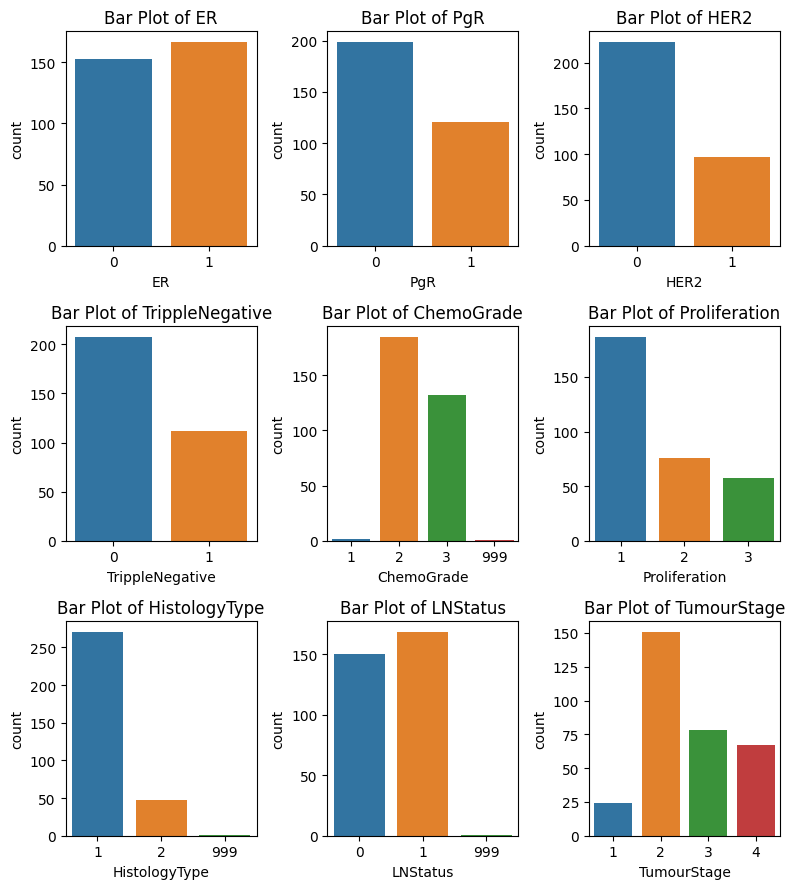

In [11]:
# Bar plots for categorical features

# Calculate the number of rows and columns for subplots
num_cols = 3  # You can adjust the number of columns as per your preference
num_rows = (len(categorical_cols) + num_cols - 1) // num_cols
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 3 * num_rows))
# Flatten the axes array
axes = axes.flatten()
# Loop through categorical columns and create bar plots
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df_train, ax=axes[i])
    axes[i].set_title(f"Bar Plot of {col}")
# Remove empty subplots if any
for j in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[j])
# Adjust layout to prevent overlapping
plt.tight_layout()
# Show the plot
plt.show()

In [12]:
'''# Remove rows where any of the specified columns has the value 999

cols_to_check = ['ChemoGrade', 'HistologyType', 'LNStatus']  # Add other columns as needed

df_train = df_train[~df_train[cols_to_check].eq(999).any(axis=1)]
df_test = df_test[~df_test[cols_to_check].eq(999).any(axis=1)]'''


# Step 1: Create 'Age_group' column
df_train['Age_group'] = pd.cut(df_train['Age'], bins=range(0, 101, 10), right=False, labels=range(10))
df_test['Age_group'] = pd.cut(df_test['Age'], bins=range(0, 101, 10), right=False, labels=range(10))

# Step 2: Impute incorrect class (999) in specified categorical columns
cols_to_check = ['ChemoGrade', 'HistologyType', 'LNStatus']

fillna_mappers = {}

for cat_col in categorical_cols:
    # Print rows with '999' before replacement
    print(f"Unique values in {cat_col} before replacement:")
    print(df_train[cat_col].value_counts())

    # Replace '999' with mode of corresponding age group
    fillna_mapper = dict(df_train.groupby(['Age_group'])[cat_col].agg(lambda x: pd.Series.mode(x).iat[0] if len(x) > 0 else np.nan))
    df_train.loc[df_train[cat_col] == 999, cat_col] = df_train.loc[df_train[cat_col] == 999]["Age_group"].map(fillna_mapper)
    df_test.loc[df_test[cat_col] == 999, cat_col] = df_test.loc[df_test[cat_col] == 999]["Age_group"].map(fillna_mapper)

    print(f"Unique values in {cat_col} after replacement:")
    print(df_train[cat_col].value_counts())

    fillna_mappers[cat_col] = fillna_mapper

Unique values in ER before replacement:
1    167
0    153
Name: ER, dtype: int64
Unique values in ER after replacement:
1    167
0    153
Name: ER, dtype: int64
Unique values in PgR before replacement:
0    199
1    121
Name: PgR, dtype: int64
Unique values in PgR after replacement:
0    199
1    121
Name: PgR, dtype: int64
Unique values in HER2 before replacement:
0    223
1     97
Name: HER2, dtype: int64
Unique values in HER2 after replacement:
0    223
1     97
Name: HER2, dtype: int64
Unique values in TrippleNegative before replacement:
0    208
1    112
Name: TrippleNegative, dtype: int64
Unique values in TrippleNegative after replacement:
0    208
1    112
Name: TrippleNegative, dtype: int64
Unique values in ChemoGrade before replacement:
2      185
3      132
1        2
999      1
Name: ChemoGrade, dtype: int64
Unique values in ChemoGrade after replacement:
2      186
3      132
1        2
999      0
Name: ChemoGrade, dtype: int64
Unique values in Proliferation before replaceme

In [13]:
fillna_mappers

{'ER': {0: nan,
  1: nan,
  2: 1.0,
  3: 0.0,
  4: 1.0,
  5: 0.0,
  6: 1.0,
  7: 1.0,
  8: nan,
  9: nan},
 'PgR': {0: nan,
  1: nan,
  2: 1.0,
  3: 0.0,
  4: 1.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: nan,
  9: nan},
 'HER2': {0: nan,
  1: nan,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: nan,
  9: nan},
 'TrippleNegative': {0: nan,
  1: nan,
  2: 0.0,
  3: 1.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: nan,
  9: nan},
 'ChemoGrade': {0: nan,
  1: nan,
  2: 2.0,
  3: 3.0,
  4: 2.0,
  5: 2.0,
  6: 2.0,
  7: 3.0,
  8: nan,
  9: nan},
 'Proliferation': {0: nan,
  1: nan,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: nan,
  9: nan},
 'HistologyType': {0: nan,
  1: nan,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: nan,
  9: nan},
 'LNStatus': {0: nan,
  1: nan,
  2: 0.0,
  3: 0.0,
  4: 1.0,
  5: 0.0,
  6: 1.0,
  7: 1.0,
  8: nan,
  9: nan},
 'TumourStage': {0: nan,
  1: nan,
  2: 2.0,
  3: 2.0,
  4: 2.0,
  5: 2.0,
  6: 2.0,
  7: 2.

In [14]:
y_train = df_train[target_col]
y_test = df_test[target_col]

### Remove redundant features

In [15]:
# Calculate the correlation matrix
correlation_matrix = df_train[numerical_cols].corr()

# Set a correlation threshold
correlation_threshold = 0.9

# Find and remove highly correlated features
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]

            # Check correlation with the target variable y
            corr_with_y_i = df_train[colname_i].corr(y_train)
            corr_with_y_j = df_train[colname_j].corr(y_train)

            # Choose the column with lower absolute correlation with y to remove
            col_to_remove = colname_i if abs(corr_with_y_i) < abs(corr_with_y_j) else colname_j

            correlated_features.add((colname_i, colname_j, col_to_remove))
            print(f'Highly correlated features: {colname_i} and {colname_j} (Correlation: {correlation_matrix.iloc[i, j]:.2f})')
            print(f'Correlation with y: {colname_i} - {corr_with_y_i:.2f}, {colname_j} - {corr_with_y_j:.2f}')


df_train_unique = df_train[numerical_cols].drop(columns=[col[2] for col in correlated_features])
numerical_cols = df_train_unique.select_dtypes(include='number').columns.tolist()

print("Identical features removed:")
for col in correlated_features:
    print(f"{col[2]}")

Highly correlated features: original_shape_Maximum3DDiameter and original_shape_MajorAxisLength (Correlation: 0.92)
Correlation with y: original_shape_Maximum3DDiameter - -0.14, original_shape_MajorAxisLength - -0.14
Highly correlated features: original_shape_Maximum3DDiameter and original_shape_Maximum2DDiameterSlice (Correlation: 0.96)
Correlation with y: original_shape_Maximum3DDiameter - -0.14, original_shape_Maximum2DDiameterSlice - -0.14
Highly correlated features: original_shape_SurfaceArea and original_shape_MeshVolume (Correlation: 0.96)
Correlation with y: original_shape_SurfaceArea - -0.05, original_shape_MeshVolume - -0.06
Highly correlated features: original_shape_VoxelVolume and original_shape_MeshVolume (Correlation: 1.00)
Correlation with y: original_shape_VoxelVolume - -0.06, original_shape_MeshVolume - -0.06
Highly correlated features: original_shape_VoxelVolume and original_shape_SurfaceArea (Correlation: 0.96)
Correlation with y: original_shape_VoxelVolume - -0.06, 

In [16]:
# Prepare Input Data

X_train = pd.concat([df_train[numerical_cols], df_train[categorical_cols]], axis=1)
X_test = pd.concat([df_test[numerical_cols], df_test[categorical_cols]], axis=1)

### Split internal validation set to select model params

In [17]:
from sklearn.preprocessing import RobustScaler

#scaler = RobustScaler()
#X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
#X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_t, X_val, y_train_t, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.2, random_state=2)

In [18]:
df_result = pd.DataFrame()
for max_depth in [2, 3, 4]:
  for n_estimators in [50, 100, 150]:
    for learning_rate in [0.001, 0.005, 0.01]:
      for alpha in [0, 0.05, 0.1]:
        params = {
        'objective': 'reg:squarederror',
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'alpha':alpha,
        'categorical_feature': categorical_cols
        }
        test_model = XGBRegressor(**params,enable_categorical = True)
        test_model.fit(X_train_t, y_train_t, eval_set=[(X_val, y_val)], verbose=0, early_stopping_rounds=10)
        y_val_pred = test_model.predict(X_val)
        mae_val = metrics.mean_absolute_error(y_val, y_val_pred)
        result = {
            "best_iteration":test_model.best_iteration,
            "best_mse":test_model.best_score,
            "mae_val": mae_val
        }
        result.update(params)
        df_result = df_result.append(result, ignore_index=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:27:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "categorical_feature" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-18-7c21247ec6f6>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_result = df_result.append(result, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/x

In [19]:
df_result.sort_values('mae_val') ##

,best_iteration,best_mse,mae_val,objective,n_estimators,learning_rate,max_depth,alpha,categorical_feature
79,147,24.509646,18.403371,reg:squarederror,150,0.010,4,0.05,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
80,148,24.517634,18.436537,reg:squarederror,150,0.010,4,0.10,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
52,149,24.694341,18.446489,reg:squarederror,150,0.010,3,0.05,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
51,149,24.750410,18.450108,reg:squarederror,150,0.010,3,0.00,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
53,146,24.693847,18.460721,reg:squarederror,150,0.010,3,0.10,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
...,...,...,...,...,...,...,...,...,...
64,99,26.874769,20.518215,reg:squarederror,100,0.001,4,0.05,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
63,99,26.875943,20.518816,reg:squarederror,100,0.001,4,0.00,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
56,49,26.953213,20.542483,reg:squarederror,50,0.001,4,0.10,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."
55,49,26.953222,20.542519,reg:squarederror,50,0.001,4,0.05,"[ER, PgR, HER2, TrippleNegative, ChemoGrade, P..."


### Refit best model with full sample

In [20]:
params = {
    'objective': 'reg:squarederror',
    'n_estimators': 150,
    'learning_rate': 0.010,
    'max_depth': 4,
    'alpha':0.05,
}

# XGBoost Model
model = XGBRegressor(**params,enable_categorical = True)

# Fit the model
model.fit(X_train, y_train)

XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, ...)

In [21]:
# Make predictions on training and testing sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Convert predictions from DMatrix to numpy array
y_train_pred_np = np.asarray(y_train_pred)
y_test_pred_np = np.asarray(y_test_pred)

# Evaluate the model
rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_np))
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_np))

r2_train = metrics.r2_score(y_train, y_train_pred_np)
r2_test = metrics.r2_score(y_test, y_test_pred_np)

mae_train = metrics.mean_absolute_error(y_train, y_train_pred_np)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred_np)


print(f'Training RMSE: {rmse_train:.4f}, R^2: {r2_train:.4f}, MAE: {mae_train:.4f}')
print(f'Testing RMSE: {rmse_test:.4f}, R^2: {r2_test:.4f}, MAE: {mae_test:.4f}')

Training RMSE: 16.8516, R^2: 0.5667, MAE: 13.5068
Testing RMSE: 30.3065, R^2: 0.1211, MAE: 24.1293


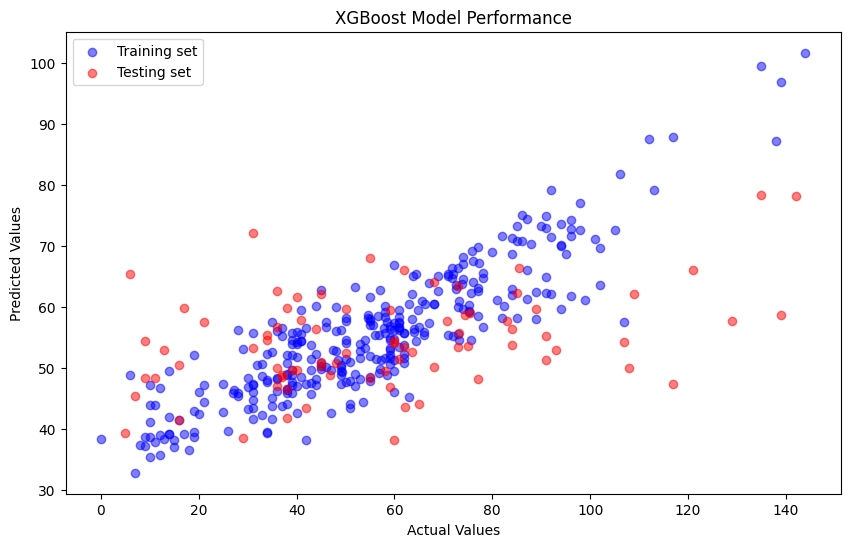

In [22]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))

plt.scatter(y_train, y_train_pred_np, label='Training set', color='blue', alpha=0.5)
plt.scatter(y_test, y_test_pred_np, label='Testing set', color='red', alpha=0.5)

plt.title('XGBoost Model Performance')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

### Save final model and other related object

In [23]:
with open(f"{BASE_PATH}/regression_model.pkl", 'wb') as model_file:
  pickle.dump(model, model_file)

with open(f"{BASE_PATH}/categorical_cols_regression.pkl", 'wb') as cat_col_file:
  pickle.dump(categorical_cols, cat_col_file)

with open(f"{BASE_PATH}/numerical_cols_regression.pkl", 'wb') as num_col_file:
  pickle.dump(numerical_cols, num_col_file)

with open(f"{BASE_PATH}/fillna_mappers_regression.pkl", 'wb') as fillna_mappers_file:
  pickle.dump(fillna_mappers, fillna_mappers_file)
